In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
sys.path.insert(0, "../code-previous")
sys.path.insert(0, "..")

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import sklearn.feature_extraction as skfeatures
import utils
import time
import os

import nltk
stopwords = nltk.corpus.stopwords.words('english')

from unicodedata import category
from tqdm import tqdm
tqdm.pandas(desc="Progress")

import seaborn as sns
sns.set()


import matplotlib.pyplot as plt
path2rawdata = '/mnt/disks/vault/wos2017-parsed/'

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [4]:
raw_data_path = "/mnt/disks/vault/analysis-data/raw_data_full/raw_data_full.pql"
data = pd.read_pickle(raw_data_path)

In [5]:
print(len(data))

738469


__There are more than 730,000 Applied Physics articles__

In [6]:
# Dropping all the NaNs - Just making sure that our data is clean

data = data.dropna()
print(data['Label'].unique())

['Physics, Applied']


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f0039e10dd8>]],
      dtype=object)

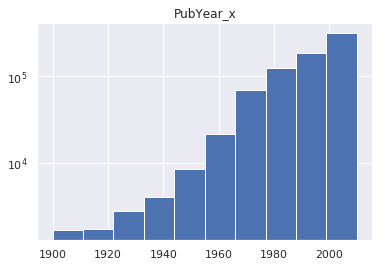

In [7]:
# How does the count of articles vary with year
data.hist(column='PubYear_x', log=True)

__Applied Physics articles are increasing steadily__

In [8]:
# How are the average citations of physics articles varying - let us add 1 to add citation for normalization
data['log_c5'] = data['c5'].progress_apply(lambda x: np.log(x+1))

Progress: 100%|██████████| 738469/738469 [00:01<00:00, 478936.46it/s]


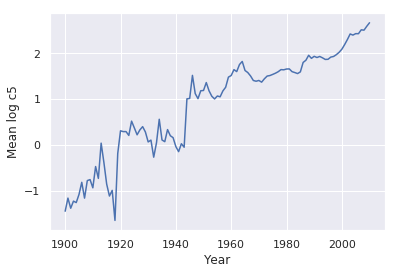

In [9]:
# How is log_c5 varying with years
average_citations_groupedby_year = data.groupby('PubYear_x', as_index=False)['c5'].mean()
average_citations_groupedby_year["mean_log_c5"] = average_citations_groupedby_year['c5'].apply(lambda x: np.log(x))
plt.plot(average_citations_groupedby_year['PubYear_x'], average_citations_groupedby_year['mean_log_c5'])
plt.xlabel("Year")
plt.ylabel("Mean log c5")
plt.show() 

__The average number of citations per year is increasing__

Progress: 100%|██████████| 738469/738469 [00:00<00:00, 860550.85it/s] 
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


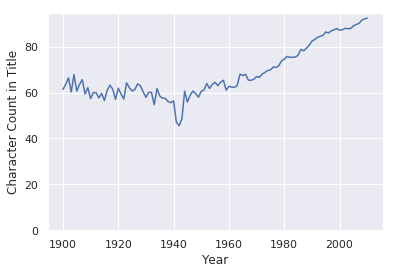

In [10]:
# How is the yearly variation of average character count in titles? - no clean up, everything including punctuations
# are considered
data['character_count'] = data['Title'].progress_apply(lambda x: len(x))
average_character_count_groupedby_year = data.groupby('PubYear_x', as_index=False)['character_count'].mean()
plt.plot(average_character_count_groupedby_year['PubYear_x'], 
         average_character_count_groupedby_year['character_count'])
plt.ylim(ymin=0)
plt.xlabel("Year")
plt.ylabel("Character Count in Title")
plt.show() 

__Papers in the 1940s have relatively a little short titles in comparison?__

Progress: 100%|██████████| 738469/738469 [00:01<00:00, 544097.46it/s]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


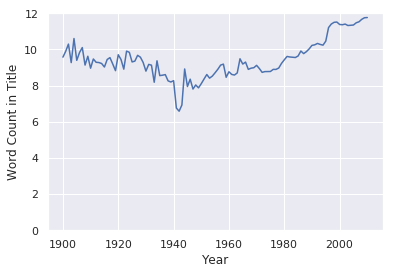

In [11]:
# How has word counts in title varying over the years?
data["word_count"] = data["Title"].progress_apply(lambda x: len(x.split()))
average_word_count_groupedby_year = data.groupby('PubYear_x', as_index=False)["word_count"].mean()

plt.plot(average_word_count_groupedby_year['PubYear_x'], 
         average_word_count_groupedby_year['word_count'])
plt.ylim(ymin=0)
plt.xlabel("Year")
plt.ylabel("Word Count in Title")
plt.show() 

In [12]:
# Let us clean up the titles and plot the same graph - word count on cleaned titles

data['title_without_punct'] = data['Title'].progress_apply(lambda x: 
                                                           str.lower(''.join(ch for ch in str(x) if category(ch)[0] != 'P')))

data["title_without_stopwords"] = data['title_without_punct'].progress_apply(lambda x: 
                                                                            " ".join([word for word in x.split() if word not in stopwords]))

data.head()

Progress: 100%|██████████| 738469/738469 [00:15<00:00, 49022.32it/s]


,ArticleID,Type,Label,PubYear_x,Doctypes,Title,Journal,Journal Abbreviation ISO,PubYear_y,c5,log_c5,character_count,word_count,title_without_punct,title_without_stopwords
0,A1981LJ96300019,ASCA traditional subject,"Physics, Applied",1981,Article,SURFACE COMPOSITIONAL MODIFICATIONS DURING O-2...,APPLIED PHYSICS LETTERS,Appl. Phys. Lett.,1981,6.0,1.945910,76,8,surface compositional modifications during o2+...,surface compositional modifications o2+ bombar...
1,A1981MM58300017,ASCA traditional subject,"Physics, Applied",1981,Article,ELECTRON-PHONON INTERACTION AND DEVIATIONS FRO...,JOURNAL OF PHYSICS F-METAL PHYSICS,,1981,0.0,0.000000,85,9,electronphonon interaction and deviations from...,electronphonon interaction deviations matthies...
2,A1981LV54600009,ASCA traditional subject,"Physics, Applied",1981,Article,EXPLOSIVE GENERATION OF ELECTROMAGNETIC-RADIAT...,ZHURNAL TEKHNICHESKOI FIZIKI,Zhurnal Tek. Fiz.,1981,0.0,0.000000,88,11,explosive generation of electromagneticradiati...,explosive generation electromagneticradiation ...
3,A1981LX06200023,ASCA traditional subject,"Physics, Applied",1981,Article,PIEZOELECTRIC ZNO TRANSDUCERS PRODUCED BY R.F....,THIN SOLID FILMS,Thin Solid Films,1981,7.0,2.079442,67,8,piezoelectric zno transducers produced by rf m...,piezoelectric zno transducers produced rf magn...
4,A1981LG93900006,ASCA traditional subject,"Physics, Applied",1981,Article,A MODEL FOR INHOMOGENEOUS CONDUCTION IN ANISOT...,JOURNAL OF PHYSICS F-METAL PHYSICS,,1981,3.0,1.386294,84,12,a model for inhomogeneous conduction in anisot...,model inhomogeneous conduction anisotropic mat...


Progress: 100%|██████████| 738469/738469 [00:01<00:00, 592556.75it/s]
/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


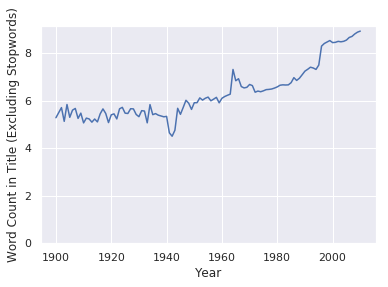

In [13]:
data["cleaned_title_word_count"] = data["title_without_stopwords"].progress_apply(lambda x: len(x.split()))
average_word_count_groupedby_year = data.groupby('PubYear_x', as_index=False)["cleaned_title_word_count"].mean()

plt.plot(average_word_count_groupedby_year['PubYear_x'], 
         average_word_count_groupedby_year['cleaned_title_word_count'])
plt.ylim(ymin=0)
plt.xlabel("Year")
plt.ylabel("Word Count in Title (Excluding Stopwords)")

plt.show() 

__The graph looks identical to the one above, but with a small drop in the word counts__

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


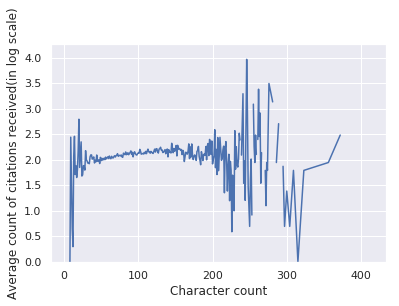

In [14]:
# What is the variation in average citation counts with the character count in the title?

character_counts_grouped = data.groupby('character_count', as_index=False)['c5'].mean()
character_counts_grouped["mean_log_c5"] = character_counts_grouped['c5'].apply(lambda x: np.log(x))
plt.plot(character_counts_grouped['character_count'], 
         character_counts_grouped['mean_log_c5'])

plt.ylim(ymin=0)
plt.xlabel("Character count")
plt.ylabel("Average count of citations received(in log scale)")

plt.show() 

/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:3604: MatplotlibDeprecationWarning: 
The `ymin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `bottom` instead.
  alternative='`bottom`', obj_type='argument')


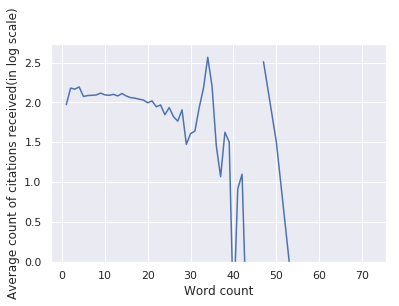

In [15]:
# What is the variation in average citation counts with the word count in the title?
word_counts_grouped = data.groupby('word_count', as_index=False)['c5'].mean()
word_counts_grouped["mean_log_c5"] = word_counts_grouped['c5'].apply(lambda x: np.log(x))

plt.plot(word_counts_grouped['word_count'], 
         word_counts_grouped['mean_log_c5'])
plt.ylim(ymin=0)
plt.xlabel("Word count")
plt.ylabel("Average count of citations received(in log scale)")

plt.show() 